___

# 1. Import & Config

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import ParameterGrid

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, random_split, WeightedRandomSampler
from torch.utils.data.dataloader import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [3]:
training_path = "/storage/datasets/visione-artificiale/Warp-C/train_balanced/"
validation_path = "/storage/datasets/visione-artificiale/Warp-C/validation_balanced/"

In [4]:
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
torch.multiprocessing.set_sharing_strategy("file_system")

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# 2. Training Parameters

In [6]:
img_height, img_width = 128, 128

num_workers = 8

mean_channel_1 = 0.337052
mean_channel_2 = 0.344904
mean_channel_3 = 0.351085
std_channel_1 = 0.180601
std_channel_2 = 0.176718
std_channel_3 = 0.183093

# 3. Data augmentation

In [7]:
# Define the transformation to apply to the images
augmentation_transform = transforms.Compose([
    # Resize image
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    
    transforms.RandomHorizontalFlip(p=.2),
    transforms.RandomVerticalFlip(p=.2),
    transforms.RandomApply([transforms.RandomRotation(degrees=45)], p=.2),
    transforms.RandomPerspective(distortion_scale=0.3, p=.2),
    transforms.RandomAdjustSharpness(sharpness_factor=5, p=.2),
    transforms.RandomAutocontrast(p=.2),

    # Color normalization
    transforms.Normalize(
        mean=(mean_channel_1, mean_channel_2, mean_channel_3),
        std=(std_channel_1, std_channel_2, std_channel_3)
    )
])

base_transform = transforms.Compose([
    # Resize image
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),

    # Color normalization
    transforms.Normalize(
        mean=(mean_channel_1, mean_channel_2, mean_channel_3),
        std=(std_channel_1, std_channel_2, std_channel_3)
    )
])

In [8]:
# ImageFolder Datasets
train_dataset = ImageFolder(root=training_path, transform=augmentation_transform)
validation_dataset = ImageFolder(root=validation_path, transform=base_transform)

### Dataset stats

In [9]:
class_labels = train_dataset.classes
num_classes = len(class_labels)
print(f"Dataset loaded with {num_classes} classes")
print("Classes:", *class_labels, sep=", ", end="\n\n")

print(f"Training images: {len(train_dataset.imgs)}")
print(f"Validation images: {len(validation_dataset.imgs)}")

Dataset loaded with 28 classes
Classes:, bottle-blue, bottle-blue-full, bottle-blue5l, bottle-blue5l-full, bottle-dark, bottle-dark-full, bottle-green, bottle-green-full, bottle-milk, bottle-milk-full, bottle-multicolor, bottle-multicolorv-full, bottle-oil, bottle-oil-full, bottle-transp, bottle-transp-full, bottle-yogurt, canister, cans, detergent-box, detergent-color, detergent-transparent, detergent-white, glass-dark, glass-green, glass-transp, juice-cardboard, milk-cardboard

Training images: 7222
Validation images: 803


___

# 4. Model training

### 4.1 CNN model architecture

In [10]:
class CNN(nn.Module):
    def __init__(self, conv_units=None, learning_rate=None, weight_decay=None, dropout_rate=None, batch_size=None):
        super().__init__()
        self.name = f"CNN_{img_width}x{img_height}_{batch_size}bs_{learning_rate}lr_{weight_decay}wd_{conv_units}conv_{dropout_rate}dr"

        self.features_conv = nn.Sequential(
            nn.Conv2d(3, conv_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_units),
            nn.ReLU(),
            nn.Conv2d(conv_units, conv_units*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_units*2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(conv_units*2, conv_units*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(units*4),
            nn.ReLU(),
            nn.Conv2d(conv_units*4, conv_units*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_units*4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(conv_units*4, conv_units*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_units*8),
            nn.ReLU(),
            nn.Conv2d(conv_units*8, conv_units*8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(conv_units*8),
            nn.ReLU()
        )

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.classifier = nn.Sequential(            
            nn.Flatten(),
            nn.Linear(conv_units * 8 * (img_width // 8) * (img_height // 8), 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

        self.gradients = None
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

    def forward(self, x):
        x = self.features_conv(x)
        x = self.max_pool(x)
        x = self.classifier(x)
        return x

In [11]:
@torch.no_grad()
def evaluate(model, data_loader):
    # Validation loop
    model.eval() # Set the model to evaluation mode

    y_labels, y_preds = [], []
    
    for images, labels in tqdm(data_loader, desc="Validating model", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        
        y_labels.extend(labels.cpu())
        y_preds.extend(predicted.cpu())

    acc = accuracy_score(y_labels, y_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_labels, y_preds, average="macro", zero_division=0)

    return acc, prec, rec, f1

In [12]:
def fit(model, data_loader):
    model.train()  # Set the model to training mode
    for images, labels in tqdm(data_loader, desc="Batch", leave=False):
        model.optimizer.zero_grad()

        # Move the data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        with autocast():
            outputs = model(images)
            loss = model.criterion(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(model.optimizer)
        scaler.update()

    return model, loss.item()

### 4.2 Hyperparameter grid definition

In [13]:
hyperparameters = {
    'learning_rate': [0.0005, 0.0001],
    'conv_units': [16, 32, 64],
    'batch_size': [16, 64, 128],
    'dropout_rate': [0, 0.2],
    'weight_decay': [0.01, 0.001]
}
hyperparameter_grid = list(ParameterGrid(hyperparameters))

# Removing combinations where batch_size=128 and conv_units=64 from grid, since they consume more gpu memory than available
hyperparameter_grid = list(filter(lambda c: not ((c["batch_size"] == 128) and (c["conv_units"] == 64)), hyperparameter_grid))
hyperparameter_grid = list(filter(lambda c: not ((c["batch_size"] == 64) and (c["conv_units"] == 64)), hyperparameter_grid))

print(f"Evaluating {len(hyperparameter_grid)} parameter combinations")
hyperparameter_grid = pd.DataFrame(hyperparameter_grid)
hyperparameter_grid

Evaluating 56 parameter combinations


,batch_size,conv_units,dropout_rate,learning_rate,weight_decay
0,16,16,0.0,0.0005,0.010
1,16,16,0.0,0.0005,0.001
2,16,16,0.0,0.0001,0.010
3,16,16,0.0,0.0001,0.001
4,16,16,0.2,0.0005,0.010
5,16,16,0.2,0.0005,0.001
6,16,16,0.2,0.0001,0.010
7,16,16,0.2,0.0001,0.001
8,16,32,0.0,0.0005,0.010
9,16,32,0.0,0.0005,0.001


### 4.3 Fit models

In [14]:
### Hyperparameter-tuning parameters
num_epochs = 100
patience = 15

### Preparing dataframe for results
restore = True
if restore:
    hyperparameter_grid = pd.read_csv("hyperparameter_tuning.csv")
else:
    hyperparameter_grid["model_name"] = None
    hyperparameter_grid["epoch"] = None
    hyperparameter_grid["train_loss"] = None
    hyperparameter_grid["valid_loss"] = None
    hyperparameter_grid["valid_precision"] = None
    hyperparameter_grid["valid_recall"] = None
    hyperparameter_grid["valid_f1score"] = None

In [15]:
for idx, params in tqdm(hyperparameter_grid.iterrows(), desc="Hyperparameter tuning: ", total=len(hyperparameter_grid)):
    # Skip already trained models
    if not np.isnan(params.epoch): continue
    if (params["batch_size"] == 64) and (params["conv_units"] == 64): continue

    # Variables for model training status
    history = []
    patience_counter = 0
    early_stopping_epoch = -1
    best_loss = -1
    scaler = torch.cuda.amp.GradScaler()

    # Load dataset
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=num_workers, pin_memory=True)
    validation_loader = DataLoader(validation_dataset, batch_size=params["batch_size"], num_workers=num_workers, pin_memory=True)

    # Create model
    model = CNN(conv_units=params["conv_units"], learning_rate=params["learning_rate"], weight_decay=params["weight_decay"], dropout_rate=params["dropout_rate"], batch_size=params["batch_size"])
    model = model.to(device)
    # model_output_path = 
    hyperparameter_grid.loc[idx, "model_name"] = model.name

    # Fit and evaluate model
    for epoch in (pbar := tqdm(range(1, num_epochs+1), desc=f"Model {model.name} - Epoch")):
        pbar.set_description(f"Model {model.name} - Best loss: {best_loss:.5f} - Epoch")

        # Fit and evaluate model
        model, epoch_loss = fit(model, train_loader)
        acc, prec, rec, f1 = evaluate(model, validation_loader)
        history.append({"model": model.name, "epoch": epoch, "train_loss": epoch_loss, "valid_loss": acc, "valid_precision": prec, "valid_recall": rec, "valid_f1score": f1})
        pd.DataFrame(history).to_csv(f"models/HT/{model.name}_HT.csv", index=None)

        # Early Stopping
        if acc > best_loss:
            # Update early stopping variables
            early_stopping_epoch = epoch
            best_loss = acc
            patience_counter = 0
            torch.save(model, f"models/HT/{model.name}.pt")

            # Update HT history
            hyperparameter_grid.loc[idx, "epoch"] = epoch
            hyperparameter_grid.loc[idx, "train_loss"] = epoch_loss
            hyperparameter_grid.loc[idx, "valid_loss"] = acc
            hyperparameter_grid.loc[idx, "valid_precision"] = prec
            hyperparameter_grid.loc[idx, "valid_recall"] = rec
            hyperparameter_grid.loc[idx, "valid_f1score"] = f1
            hyperparameter_grid.to_csv("hyperparameter_tuning.csv", index=None)

        else:
            patience_counter += 1
            if (patience_counter >= patience) or (patience_counter == num_epochs):
                # Stop training
                break

Hyperparameter tuning:   0%|          | 0/64 [00:00<?, ?it/s]

# 5. Best model - Hyperparameter selection

### 5.1 Hyperparameter trials

In [16]:
metric = "valid_f1score"
hyperparameter_grid = hyperparameter_grid.sort_values(by=metric, ascending=False)
hyperparameter_grid.dropna(inplace=True)
hyperparameter_grid.shape

(56, 12)

In [17]:
hyperparameter_grid.drop("model_name", axis=1)

,batch_size,conv_units,dropout_rate,learning_rate,weight_decay,epoch,train_loss,valid_loss,valid_precision,valid_recall,valid_f1score
10,16,32,0.0,0.0001,0.010,98.0,1.798022,0.640100,0.641316,0.602980,0.612174
38,64,32,0.2,0.0001,0.010,77.0,1.022439,0.618929,0.609341,0.590025,0.577858
34,64,32,0.0,0.0001,0.010,59.0,0.602962,0.613948,0.597460,0.574142,0.575760
58,128,32,0.0,0.0001,0.010,54.0,0.819514,0.602740,0.593999,0.572519,0.567621
18,16,64,0.0,0.0001,0.010,94.0,0.258298,0.626401,0.592453,0.559243,0.562138
23,16,64,0.2,0.0001,0.001,59.0,1.306478,0.595268,0.585077,0.561923,0.561441
6,16,16,0.2,0.0001,0.010,68.0,0.881551,0.607721,0.575477,0.573220,0.559547
31,64,16,0.2,0.0001,0.001,60.0,0.261370,0.601494,0.581557,0.556301,0.557837
29,64,16,0.2,0.0005,0.001,63.0,1.328469,0.602740,0.588705,0.553525,0.556410
19,16,64,0.0,0.0001,0.001,68.0,0.487192,0.587796,0.570212,0.552713,0.554573


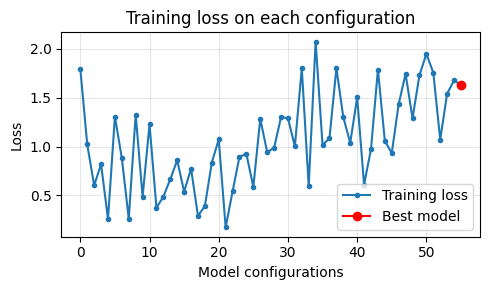

In [18]:
plt.figure(figsize=(5, 3))
plt.title("Training loss on each configuration")

# plt.plot(hyperparameter_grid.sort_values("train_loss", ascending=False).train_loss.values, ".-", label="Training loss")
# plt.plot(len(hyperparameter_grid) - 1, hyperparameter_grid.sort_values("train_loss", ascending=False).train_loss.values[-1], marker='o', markersize=6, color='red', label="Best model")

plt.plot(hyperparameter_grid.train_loss.values, ".-", label="Training loss")
plt.plot(len(hyperparameter_grid) - 1, hyperparameter_grid.train_loss.values[-1], marker='o', markersize=6, color='red', label="Best model")

plt.xlabel("Model configurations")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

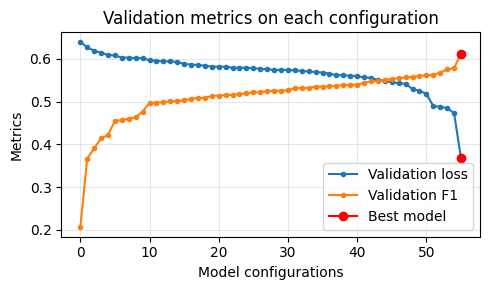

In [19]:
plt.figure(figsize=(5, 3))
plt.title("Validation metrics on each configuration")

grid_sorted = hyperparameter_grid.sort_values("valid_loss", ascending=False)
plt.plot(grid_sorted.valid_loss.values, ".-", label="Validation loss")
plt.plot(len(grid_sorted)-1, grid_sorted.valid_loss.values[-1], marker='o', markersize=6, color='red')

grid_sorted = hyperparameter_grid.sort_values("valid_f1score", ascending=True)
plt.plot(grid_sorted.valid_f1score.values, ".-", label="Validation F1")
plt.plot(len(grid_sorted)-1, grid_sorted.valid_f1score.values[-1], marker='o', markersize=6, color='red', label="Best model")

plt.xlabel("Model configurations")
plt.ylabel("Metrics")
plt.legend(loc="lower right")
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()

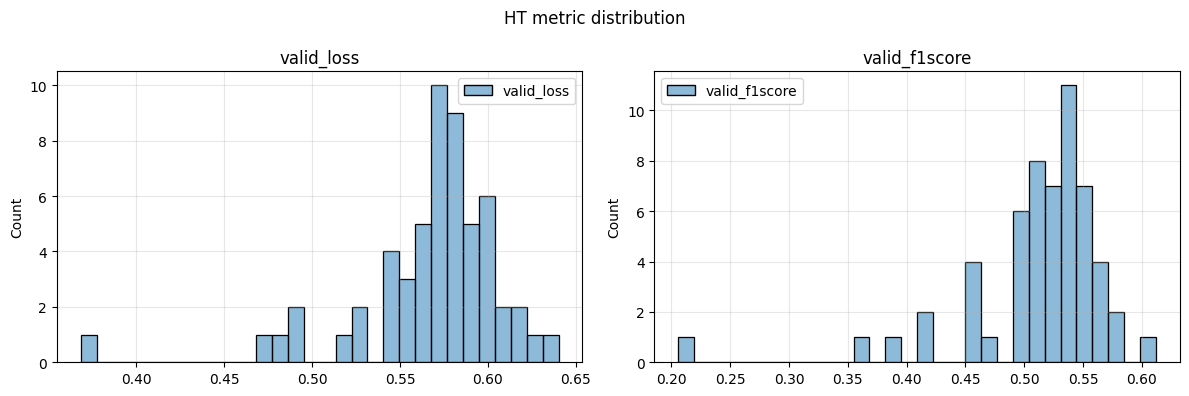

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("HT metric distribution")

ax1.set_title("valid_loss")
sns.histplot(hyperparameter_grid[["valid_loss"]], bins=30, ax=ax1)

ax2.set_title("valid_f1score")
sns.histplot(hyperparameter_grid[["valid_f1score"]], bins=30, ax=ax2)

ax1.grid(alpha=.3)
ax2.grid(alpha=.3)
plt.tight_layout()
plt.show()

### 5.2 Best model results

In [23]:
best_model_params = hyperparameter_grid.iloc[0]
best_model_params

batch_size                                                    16
conv_units                                                    32
dropout_rate                                                 0.0
learning_rate                                             0.0001
weight_decay                                                0.01
model_name         CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr
epoch                                                       98.0
train_loss                                              1.798022
valid_loss                                                0.6401
valid_precision                                         0.641316
valid_recall                                             0.60298
valid_f1score                                           0.612174
Name: 10, dtype: object

In [24]:
best_model_history = pd.read_csv(f"models/HT/{best_model_params.model_name}_HT.csv")
best_model_history

,model,epoch,train_loss,valid_loss,valid_precision,valid_recall,valid_f1score
0,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,1,3.437175,0.290162,0.184804,0.197676,0.176741
1,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,2,1.688477,0.377335,0.341178,0.315089,0.287781
2,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,3,1.447103,0.372354,0.362875,0.303458,0.278606
3,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,4,2.752726,0.391034,0.422917,0.331513,0.330762
4,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,5,2.079102,0.423412,0.363043,0.363583,0.329005
...,...,...,...,...,...,...,...
95,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,96,0.297412,0.617684,0.586875,0.572556,0.561466
96,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,97,0.517985,0.600249,0.588807,0.570761,0.560680
97,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,98,1.798022,0.640100,0.641316,0.602980,0.612174
98,CNN_128x128_16bs_0.0001lr_0.01wd_32conv_0.0dr,99,0.462285,0.617684,0.602280,0.595336,0.588005


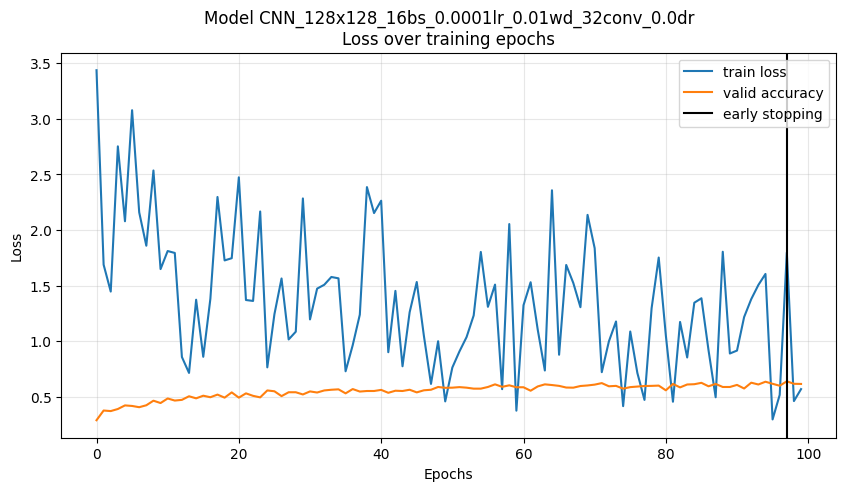

In [25]:
# Display loss
plt.figure(figsize=(10,5))
plt.title(f"Model {best_model_params.model_name}\nLoss over training epochs")
sns.lineplot(best_model_history.train_loss, label="train loss")
sns.lineplot(best_model_history.valid_loss, label="valid accuracy")
plt.axvline(x=best_model_params.epoch-1, color="black", label="early stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(alpha=.3)

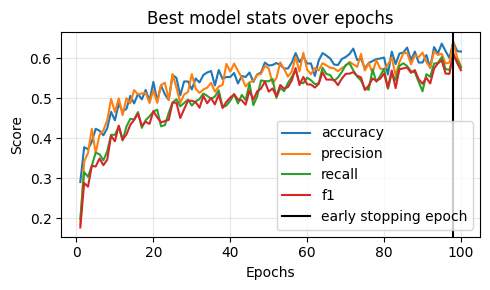

In [26]:
# Display stats
plt.figure(figsize=(5, 3))
# plt.title(f"Model {best_model_params.model_name}\nStats over epochs")
plt.title(f"Best model stats over epochs")
sns.lineplot(data=best_model_history, x="epoch", y="valid_loss", label="accuracy")
sns.lineplot(data=best_model_history, x="epoch", y="valid_precision", label="precision")
sns.lineplot(data=best_model_history, x="epoch", y="valid_recall", label="recall")
sns.lineplot(data=best_model_history, x="epoch", y="valid_f1score", label="f1")
plt.axvline(x=best_model_params.epoch, color="black", label="early stopping epoch")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.tight_layout()
plt.grid(alpha=.3)